<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch10_Model_Serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Serving

## Model Train & Save

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

In [3]:
def train(model, device, train_dataloader, optim, epoch):
    model.train()
    for b_i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        pred_prob = model(X)
        loss = F.nll_loss(pred_prob, y) # nll is the negative likelihood loss
        loss.backward()
        optim.step()
        if b_i % 10 == 0:
            print('epoch: {} [{}/{} ({:.0f}%)]\t training loss: {:.6f}'.format(
                epoch, b_i * len(X), len(train_dataloader.dataset),
                100. * b_i / len(train_dataloader), loss.item()))

In [4]:
def test(model, device, test_dataloader):
    model.eval()
    loss = 0
    success = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            pred_prob = model(X)
            loss += F.nll_loss(pred_prob, y, reduction='sum').item()  # loss summed across the batch
            pred = pred_prob.argmax(dim=1, keepdim=True)  # us argmax to get the most likely prediction
            success += pred.eq(y.view_as(pred)).sum().item()

    loss /= len(test_dataloader.dataset)

    print('\nTest dataset: Overall Loss: {:.4f}, Overall Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, success, len(test_dataloader.dataset),
        100. * success / len(test_dataloader.dataset)))

In [5]:
# The mean and standard deviation values are calculated as the mean of all pixel values of all images in the training dataset
train_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))])), # train_X.mean()/256. and train_X.std()/256.
    batch_size=32, shuffle=True)

test_dataloader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1302,), (0.3069,))
                   ])),
    batch_size=500, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 164184211.91it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 121866895.20it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52913027.22it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20684613.21it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [6]:
torch.manual_seed(0)
device = torch.device("cpu")

model = ConvNet()
optimizer = optim.Adadelta(model.parameters(), lr=0.5)

In [7]:
for epoch in range(1, 3):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


epoch: 1 [0/60000 (0%)]	 training loss: 2.310609
epoch: 1 [320/60000 (1%)]	 training loss: 1.924132
epoch: 1 [640/60000 (1%)]	 training loss: 1.313337
epoch: 1 [960/60000 (2%)]	 training loss: 0.796470
epoch: 1 [1280/60000 (2%)]	 training loss: 0.819801
epoch: 1 [1600/60000 (3%)]	 training loss: 0.678430
epoch: 1 [1920/60000 (3%)]	 training loss: 0.477187
epoch: 1 [2240/60000 (4%)]	 training loss: 0.529062
epoch: 1 [2560/60000 (4%)]	 training loss: 0.468848
epoch: 1 [2880/60000 (5%)]	 training loss: 0.242855
epoch: 1 [3200/60000 (5%)]	 training loss: 0.520190
epoch: 1 [3520/60000 (6%)]	 training loss: 0.266329
epoch: 1 [3840/60000 (6%)]	 training loss: 0.473294
epoch: 1 [4160/60000 (7%)]	 training loss: 0.422828
epoch: 1 [4480/60000 (7%)]	 training loss: 0.322728
epoch: 1 [4800/60000 (8%)]	 training loss: 0.498349
epoch: 1 [5120/60000 (9%)]	 training loss: 0.149704
epoch: 1 [5440/60000 (9%)]	 training loss: 0.369297
epoch: 1 [5760/60000 (10%)]	 training loss: 0.085426
epoch: 1 [6080/60

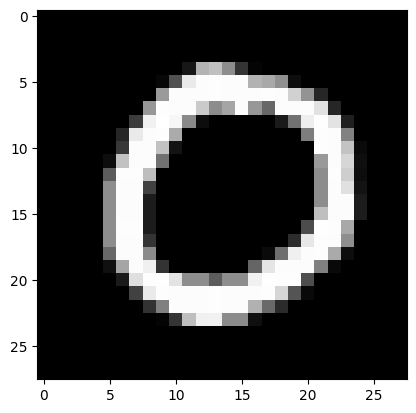

In [8]:
test_samples = enumerate(test_dataloader)
b_i, (sample_data, sample_targets) = next(test_samples)

plt.imshow(sample_data[0][0], cmap='gray', interpolation='none')
plt.show()

In [9]:
print(f"Model prediction is : {model(sample_data).data.max(1)[1][0]}")
print(f"Ground truth is : {sample_targets[0]}")

Model prediction is : 0
Ground truth is : 0


모델의 매개변수만 저장

In [10]:
PATH_TO_MODEL = "./convnet.pth"
torch.save(model.state_dict(), PATH_TO_MODEL)

### Model Load

In [11]:
import numpy as np
from PIL import Image

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.cn1 = nn.Conv2d(1, 16, 3, 1)
        self.cn2 = nn.Conv2d(16, 32, 3, 1)
        self.dp1 = nn.Dropout2d(0.10)
        self.dp2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(4608, 64) # 4608 is basically 12 X 12 X 32
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.cn1(x)
        x = F.relu(x)
        x = self.cn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dp1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp2(x)
        x = self.fc2(x)
        op = F.log_softmax(x, dim=1)
        return op

model = ConvNet()

모델 정의는 원래 python script로 `cnn_model.py` 로 저장되고,  
```python
from cnn_model import ConvNet
model = ConvNet()
```
으로 작성된다.

이 실습의 경우 Jupyter로 작업하므로 모델 정의를 다시 쓰고 인스턴스화한다.

In [13]:
PATH_TO_MODEL = "./convnet.pth"
model.load_state_dict(torch.load(PATH_TO_MODEL, map_location="cpu"))

<All keys matched successfully>

`<All keys matched successfully>` : 매개변수 로딩에 성공. 즉, 우리가 인스턴스화한 모델의 매개변수가 저장한 모델과 동일한 구조를 갖는다는 뜻.

In [14]:
model.eval()

ConvNet(
  (cn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (cn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (dp1): Dropout2d(p=0.1, inplace=False)
  (dp2): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

로딩된 모델의 매개변수 값을 업데이트 또는 변경하지 않게 evaluation 모드로 지정

In [17]:
image = Image.open("./digit_image.jpg")

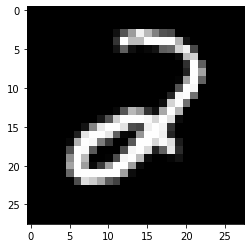

In [19]:
image

### Data Preprocessing

In [20]:
def image_to_tensor(image):
    gray_image = transforms.functional.to_grayscale(image)
    resized_image = transforms.functional.resize(gray_image, (28, 28))
    input_image_tensor = transforms.functional.to_tensor(resized_image)
    input_image_tensor_norm = transforms.functional.normalize(input_image_tensor, (0.1302,), (0.3069,))
    return input_image_tensor_norm

### Model Prediction

In [21]:
input_tensor = image_to_tensor(image)

In [22]:
def run_model(input_tensor):
    model_input = input_tensor.unsqueeze(0)
    with torch.no_grad():
        model_output = model(model_input)[0]
    model_prediction = model_output.detach().numpy().argmax()
    return model_prediction

In [31]:
output = run_model(input_tensor)
print(output)
print(type(output))

2
<class 'numpy.int64'>


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [32]:
def debug_model(input_tensor):
    model_input = input_tensor.unsqueeze(0)
    with torch.no_grad():
        model_output = model(model_input)[0]
    model_prediction = model_output.detach().numpy()
    return np.exp(model_prediction)

디버깅을 위해 원래 리스트를 변환 후 출력하는 함수

In [33]:
print(debug_model(input_tensor))

[4.9872295e-05 9.5596715e-07 9.9590880e-01 1.3675040e-04 1.5207384e-04
 3.4323725e-07 7.9911570e-06 4.4522176e-06 3.7299104e-03 8.7669405e-06]


### Post Processing

음성 인식 같은 경우 smoothing, outlier 제거 등을 통해 출력 파형을 처리해야 할 것이다.

In [34]:
def post_process(output):
    return str(output)

In [35]:
final_output = post_process(output)
print(final_output)
print(type(final_output))

2
<class 'str'>


## Server

server.py  
make_request.py